In [16]:
# Importation des librairies
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import random, numpy as np, torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision.datasets import ImageFolder
from torch.utils.data import dataloader
from torch.utils.data import SubsetRandomSampler
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reproducibilité
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


In [17]:
# Chargement du dataset 
dataset = ImageFolder(
     root="C:/Users/HP/Downloads/S3/Apprentissage profond applique/Projet UA2"
)

In [18]:
# Separer les données
ds = ImageFolder("C:/Users/HP/Downloads/S3/Apprentissage profond applique/Projet UA2")
indexes = np.arange(len(dataset))
labels = np.array(dataset.targets)  # les labels des images
index_train,index_test = train_test_split(indexes,test_size=0.2)
train_ds=SubsetRandomSampler(index_train)
test_ds=SubsetRandomSampler(index_test)



Pretraitement 

In [19]:
import torchvision.transforms as transforms

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),        # Resize 
    transforms.ToTensor(),                # En Tenseur 
    transforms.Normalize(                 # Normalisation
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

dataset.transform = data_transform


Justification des choix de ce prétraitement: L'ordre est important,

-On redimensionne d’abord avec transforms.Resize((224, 224)) pour s'assurer que toutes les images ont les mêmes dimensions afin d'assurer une cohérence des dimensions pour faciliter le traitement en lot

-On convertit en tenseur avec transforms.ToTensor() pour permettre les opérations numériques.

-On normalise les valeurs des pixels avec transforms.Normalize(                
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    ), ce qui n’est possible qu’une fois les images sous forme de tenseurs et cela permet d'augmenter la stabilité lors de l'apprentissage et d'eviter la domination de certaines donnees

CNN sans augmentation 

In [20]:

#  CNN SIMPLE 


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TRANSFORM SANS AUGMENTATION 
simple_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# DATASET 
dataset = datasets.ImageFolder("C:/Users/HP/Downloads/S3/Apprentissage profond applique/Projet UA2", transform=simple_tf)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

num_classes = len(dataset.classes)

class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                 

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                 

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                 
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x





In [21]:
model = SimpleCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [22]:
# ENTRAÎNEMENT
for epoch in range(1, 16):  
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"CNN simple {epoch}/15 - Perte moyenne : {total_loss/len(train_loader):.4f}")


CNN simple 1/15 - Perte moyenne : 1.1003
CNN simple 2/15 - Perte moyenne : 1.0797
CNN simple 3/15 - Perte moyenne : 1.0109
CNN simple 4/15 - Perte moyenne : 0.8620
CNN simple 5/15 - Perte moyenne : 0.8754
CNN simple 6/15 - Perte moyenne : 0.8409
CNN simple 7/15 - Perte moyenne : 0.7429
CNN simple 8/15 - Perte moyenne : 0.6641
CNN simple 9/15 - Perte moyenne : 0.6324
CNN simple 10/15 - Perte moyenne : 0.5994
CNN simple 11/15 - Perte moyenne : 0.5864
CNN simple 12/15 - Perte moyenne : 0.6192
CNN simple 13/15 - Perte moyenne : 0.5657
CNN simple 14/15 - Perte moyenne : 0.4833
CNN simple 15/15 - Perte moyenne : 0.4220


In [23]:
# Evaluation

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
# Precision
acc = accuracy_score(all_labels, all_preds)
print(f" Précision sur l'evaluation du modèle CNN simple: {acc*100:.2f}%")

 Précision sur l'evaluation du modèle CNN simple: 65.24%


Matrice de confusion :
 [[55  5  8]
 [ 5 57 16]
 [11 36 40]]


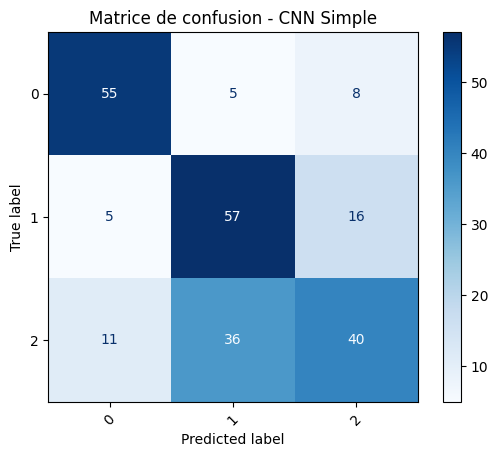

In [24]:
# MATRICE DE CONFUSION
cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion :\n", cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion - CNN Simple")
plt.show()

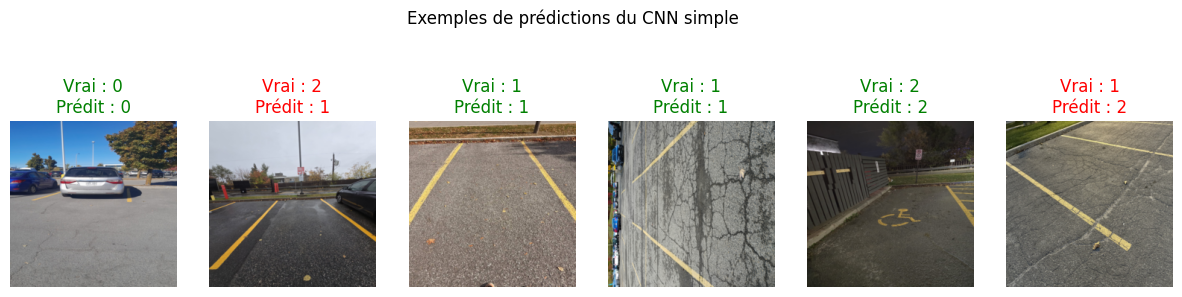

In [25]:
# Affichage de quelques prédictions
def show_predictions(model, loader, classes, n=6):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            p = out.argmax(1)
            for i in range(len(x)):
                images.append(x[i].cpu())
                labels.append(y[i].cpu())
                preds.append(p[i].cpu())
                if len(images) >= n:
                    break
            if len(images) >= n:
                break

    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        color = "green" if preds[i] == labels[i] else "red"
        axes[i].set_title(f"Vrai : {classes[labels[i]]}\nPrédit : {classes[preds[i]]}", color=color)
        axes[i].axis("off")
    plt.suptitle("Exemples de prédictions du CNN simple")
    plt.show()

show_predictions(model, val_loader, dataset.classes, n=6)

Analyse des resultats 

Nous avons tester les nombres de filtre 32,64,128 mais notre modèle avait une précision faible donc on est passé de 3 à 4 couches avec 32,64,128,256 ce qui a augmenter les performances de notre modèle

Le modèle CNN Simple a atteint une précision globale de 65,24 %, ce qui montre qu’il parvient à reconnaître une partie importante des images, mais qu’il présente encore des confusions entre certaines classes. Cette performance moyenne montre que le modèle a bien appris les caractéristiques de base.
- D'abord, Il a predit au niveau de la classe 0:
   - 55 images qu'il classe à la classe 0 
   - 5 images qu'il classe à la classe 1
   - 8 images qu'il classe à la classe 2
 Avec ces résultats de la matrice on a 55/68 images bien prédites pendant ce test de performance.On peut dire que le modèle reconnais bien la classe 0 mais porte une petite confusion sur les autres classes 1 et 2.
- Ensuite, au niveau de la classe 1 nous avons :
   - 5 images prédites à la classe 0
   - 57 images prédites à la classe 1
   - 16 images prédites à la classe 2
Ces résultats nous donnent 57/78 images bien prédites. il reconnait plus que la moyenne des images de classe 1 mais porte une confusion sur la classe 2 à cause du fait que les images de classe 1 et 2 se ressemblent parce que les images des parkings montrent des ressemblances donc il n'arrive pas à reconnaitre les caracteristiqes qui différecient une place libre et une place réservé peut-etre à cause de la maniere dont l'image a été prise selon la visibilité, la distance ce qui pourrait confondre les caracteristiques des classe 1 et 2 presque identiques.
- Enfin, au niveau de la classe 2 nous avons:
   - 11 images prédites à la classe 0
   - 36 images prédites à la classe 1
   - 40 images prédites à la classe 2
On obtient 40/87 images bien prédites et c'est légèrement en dessous de la moyenne. IL confond la classe 1 et 2 pour les memes raisons que ceux cités au niveau des résultats de la classe 1 comme la similutu du marquage au sol des places de parkings et des caractéristiques propres à la classe 2 qu'il n'arrive pas à reconnaitre à cause de la visibilité.
Sur les exemples de prédiction d'images que nous avons afficher il a prédit 4/6 bonnes images.
Il prédit bien la classe 0, prédit moyennement la classe 1 et il a des difficultés à prédire la classe 2 globalement meme s'il reussit à prédire juste une partie correctement.


Plusieurs hypothèses peuvent expliquer ces résultats. 
- Un problème visuel entre certaines caractéristiques des classes rend la distinction difficile : les images peuvent présenter des points communs tels que des lignes jaunes.
- Un CNN simple peut etre insuffisant pour dissocier des caractéristiques plus fines comme la texture.

Pour améliorer les performances, On pourrait utiliser une architecture plus profonde ou d’un modèle pré-entraîné tel que ResNet, via le transfert d’apprentissage,Cela permettrait de mieux prendre en compte les détails visuels difficile à différecier.On peut aussi ajuster des paramètres d’apprentissage, comme le taux d’apprentissage ou le choix de l’optimiseur qui pourrait améliorer la stabilité et la rapidité de l’appretissage

CNN avec augmentation

In [26]:

#  CNN AVEC AUGMENTATION


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TRANSFORMS AVEC AUGMENTATION 
aug_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

# DATASET 
dataset = datasets.ImageFolder("C:/Users/HP/Downloads/S3/Apprentissage profond applique/Projet UA2", transform=simple_tf)

train_size = int(0.8 * len(dataset))
val_size   = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

num_classes = len(dataset.classes)

class SimpleCNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),                 

            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2),                 

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
             nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                  
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x







In [27]:
# ENTRAÎNEMENT 
for epoch in range(1, 16):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    print(f"CNN + augmentation Epoch {epoch}/15 - Perte moyenne : {total_loss/len(train_loader):.4f}")

CNN + augmentation Epoch 1/15 - Perte moyenne : 0.4689
CNN + augmentation Epoch 2/15 - Perte moyenne : 0.4151
CNN + augmentation Epoch 3/15 - Perte moyenne : 0.3471
CNN + augmentation Epoch 4/15 - Perte moyenne : 0.3095
CNN + augmentation Epoch 5/15 - Perte moyenne : 0.2541
CNN + augmentation Epoch 6/15 - Perte moyenne : 0.2643
CNN + augmentation Epoch 7/15 - Perte moyenne : 0.3293
CNN + augmentation Epoch 8/15 - Perte moyenne : 0.1477
CNN + augmentation Epoch 9/15 - Perte moyenne : 0.1053
CNN + augmentation Epoch 10/15 - Perte moyenne : 0.0914
CNN + augmentation Epoch 11/15 - Perte moyenne : 0.0577
CNN + augmentation Epoch 12/15 - Perte moyenne : 0.0476
CNN + augmentation Epoch 13/15 - Perte moyenne : 0.2022
CNN + augmentation Epoch 14/15 - Perte moyenne : 0.1013
CNN + augmentation Epoch 15/15 - Perte moyenne : 0.0456


In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ÉVALUATION 
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())





Exactitude du modèle CNN + AUGMENTATION : 77.25%


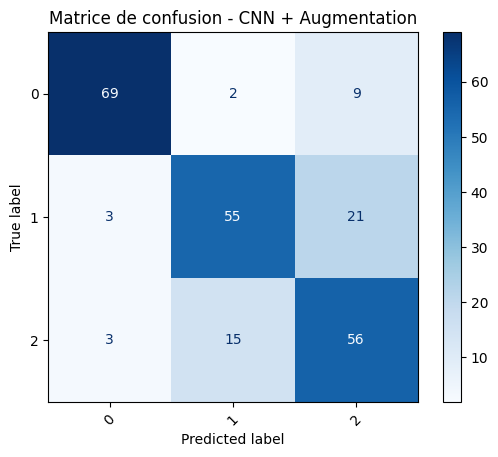

In [48]:
# Exactitude
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Exactitude du modèle CNN + AUGMENTATION : {accuracy*100:.2f}%")

# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion - CNN + Augmentation")
plt.show()

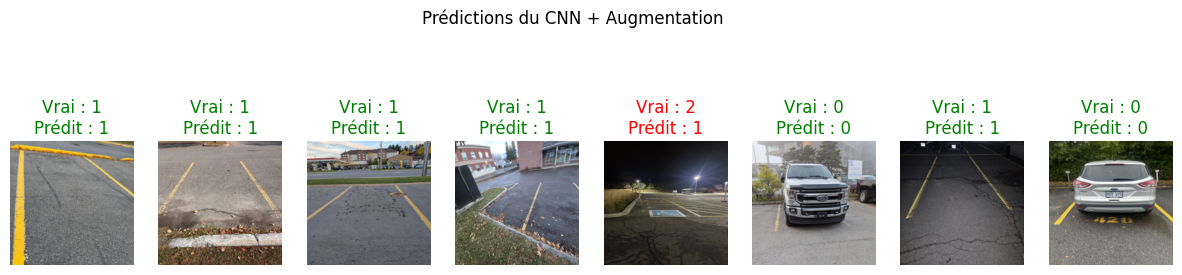

In [40]:

# AFFICHAGE DE QUELQUES PRÉDICTIONS 
def show_predictions(model, loader, classes, n=6):
    model.eval()
    images, labels, preds = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            p = out.argmax(1)
            for i in range(len(x)):
                images.append(x[i].cpu())
                labels.append(y[i].cpu())
                preds.append(p[i].cpu())
                if len(images) >= n:
                    break
            if len(images) >= n:
                break

    fig, axes = plt.subplots(1, n, figsize=(15, 4))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        color = "green" if preds[i] == labels[i] else "red"
        axes[i].set_title(f"Vrai : {classes[labels[i]]}\nPrédit : {classes[preds[i]]}", color=color)
        axes[i].axis("off")
    plt.suptitle("Prédictions du CNN + Augmentation")
    plt.show()

show_predictions(model, val_loader, dataset.classes, n=8)

Comparaison avec le modele precedent 

Le CNN avec augmentation comparé au CNN simple montre une plus grande performance avec une précision de 77.25%
Il prédit:

- Il a predit au niveau de la classe 0:
   - 69 images qu'il classe à la classe 0 
   - 2 images qu'il classe à la classe 1
   - 9 images qu'il classe à la classe 2
avec 69/80 contre 55/68 du modèle CNN simple précédent, on peut dire qu'il y'a stabilité similaire au modèle CNN simple

- Il a predit au niveau de la classe 1:
   - 3 images qu'il classe à la classe 0 
   - 55 images qu'il classe à la classe 1
   - 21 images qu'il classe à la classe 2
Nous pouvons comfirmer une baisse insignificative des bonnes prédictions 55/79  contre 57/78 du CNN simple, mais moins d’erreurs vers la classe 0

- Il a predit au niveau de la classe 2:
   - 3 images qu'il classe à la classe 0 
   - 15 images qu'il classe à la classe 1
   - 56 images qu'il classe à la classe 2
Nous constatons qu'il y'a eu amélioration avec 56/74 correctement classées contre 40/87  et beaucoup moins d’images de la classe 2 confondues avec la classe 1


Avec le résultat 7/8 bonnes prédictions des quelques images de prédictions que nous avons afficher et les résultats de notre matrice,on peut déduire qu'il y'a eu une petite augmentation de la performance grace aux transformations que nous avons effectuer avec:
- transforms.RandomResizedCrop(224) : qui apprend au modèle à reconnaître les objets quelle que soit leur position ou leur taille dans l’image
- transforms.RandomHorizontalFlip(p=0.5): qui apprend au modèle que l’objet reste le même, même s’il est orienté dans un autre sens.

dans cette partie nous avons retiré une transformation zoom_range=0.2 qu'on avait utiliser pour les images à distance mais qui a baisser la performance de notre modèle

Avec transfert 

In [ ]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Chargement du modèle pré-entraîné ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)


In [32]:
# Geler toutes les couches convolutionnelles
for param in model.parameters():
    param.requires_grad = False

In [33]:

# Remplacer la couche FC 
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes).to(device)

In [ ]:
#  Entraîner uniquement la tête 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    print(f"Feature extraction Epoch {epoch}/15 - Perte moyenne : {total_loss/len(train_loader):.4f}")

Feature extraction Epoch 1/15 - Perte moyenne : 0.7827
Feature extraction Epoch 2/15 - Perte moyenne : 0.5070
Feature extraction Epoch 3/15 - Perte moyenne : 0.4570
Feature extraction Epoch 4/15 - Perte moyenne : 0.5025
Feature extraction Epoch 5/15 - Perte moyenne : 0.4163
Feature extraction Epoch 6/15 - Perte moyenne : 0.4612
Feature extraction Epoch 7/15 - Perte moyenne : 0.3862
Feature extraction Epoch 8/15 - Perte moyenne : 0.8224
Feature extraction Epoch 9/15 - Perte moyenne : 0.6609
Feature extraction Epoch 10/15 - Perte moyenne : 0.6458
Feature extraction Epoch 11/15 - Perte moyenne : 0.4118
Feature extraction Epoch 12/15 - Perte moyenne : 0.3379
Feature extraction Epoch 13/15 - Perte moyenne : 0.2626
Feature extraction Epoch 14/15 - Perte moyenne : 0.3770
Feature extraction Epoch 15/15 - Perte moyenne : 0.3888


In [50]:
 #Fine-tuning : dégeler les couches profondes 
for name, param in model.named_parameters():
    if "layer4" in name:   # Seules les dernières couches
        param.requires_grad = True

In [52]:
# Optimiseur pour fine-tuning 
params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

for epoch in range(1, 16):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer_ft.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer_ft.step()
        total_loss += loss.item()
        
    print(f"Fine tuning Epoch {epoch}/15 - Perte moyenne : {total_loss/len(train_loader):.4f}")

Fine tuning Epoch 1/15 - Perte moyenne : 0.0425
Fine tuning Epoch 2/15 - Perte moyenne : 0.0333
Fine tuning Epoch 3/15 - Perte moyenne : 0.0334
Fine tuning Epoch 4/15 - Perte moyenne : 0.0284
Fine tuning Epoch 5/15 - Perte moyenne : 0.1800
Fine tuning Epoch 6/15 - Perte moyenne : 0.0992
Fine tuning Epoch 7/15 - Perte moyenne : 0.0936
Fine tuning Epoch 8/15 - Perte moyenne : 0.0612
Fine tuning Epoch 9/15 - Perte moyenne : 0.0744
Fine tuning Epoch 10/15 - Perte moyenne : 0.1071
Fine tuning Epoch 11/15 - Perte moyenne : 0.0275
Fine tuning Epoch 12/15 - Perte moyenne : 0.0219
Fine tuning Epoch 13/15 - Perte moyenne : 0.0160
Fine tuning Epoch 14/15 - Perte moyenne : 0.0119
Fine tuning Epoch 15/15 - Perte moyenne : 0.0230


In [53]:
import matplotlib.pyplot as plt
import torch

def imshow(img, title=None):
    # Déplacer sur CPU et convertir en numpy
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    # Dé-normalisation ImageNet
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.imshow(img)
    if title:
     plt.title(title)
     plt.axis('off')
     plt.show()

In [54]:
#Mettre le modèle en mode évaluation
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Transfert d'un batch vers le GPU
dataiter = iter(train_loader)  
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)


In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Prétraitement 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Chargement du dossier d’images
dataset = datasets.ImageFolder("C:/Users/HP/Downloads/S3/Apprentissage profond applique/Projet UA2", transform=transform)


In [60]:
# Division de train et test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [61]:
# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Précision et matrice

Précision : 96.57%
Matrice de confusion :
[[ 61   0   1]
 [  0 103   2]
 [  0   5  61]]


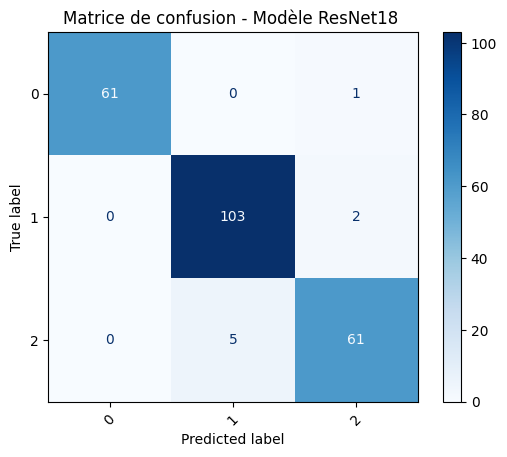

In [ ]:
# précision
from sklearn.metrics import accuracy_score, confusion_matrix

all_preds, all_labels = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        _, preds = torch.max(model(x), 1)
        all_preds += preds.cpu().tolist()
        all_labels += y.cpu().tolist()

print(f"Précision : {accuracy_score(all_labels, all_preds) * 100:.2f}%")
print("Matrice de confusion :")
print(confusion_matrix(all_labels, all_preds))
# Matrice de confusion
cm = confusion_matrix(all_labels, all_preds)
classes = ["0", "1", "2"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matrice de confusion - Modèle ResNet18 ")
plt.show()


In [63]:
#Prédictions
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)  # Indices des classes prédites

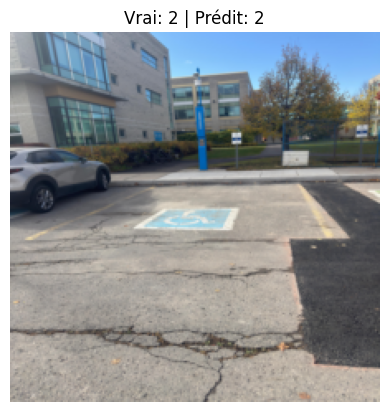

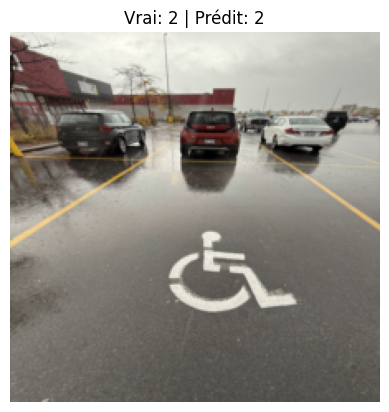

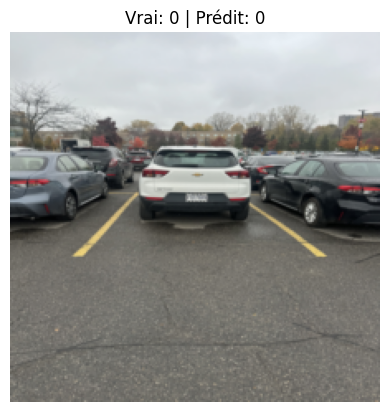

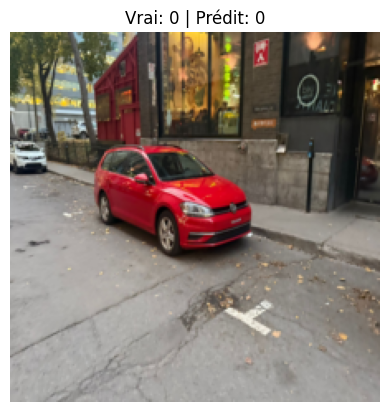

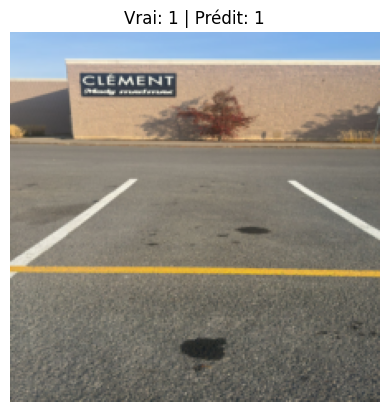

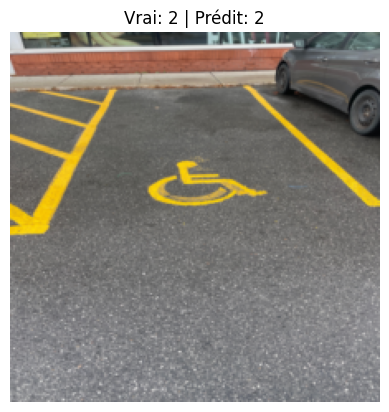

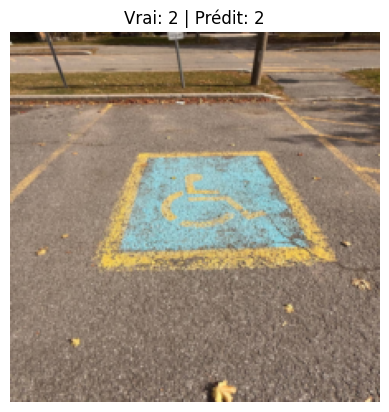

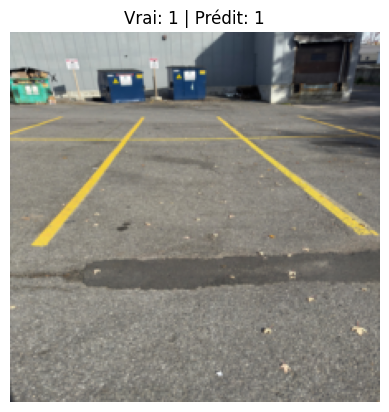

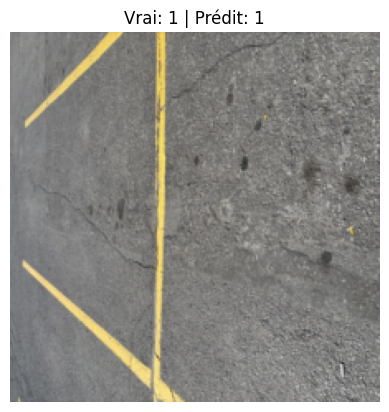

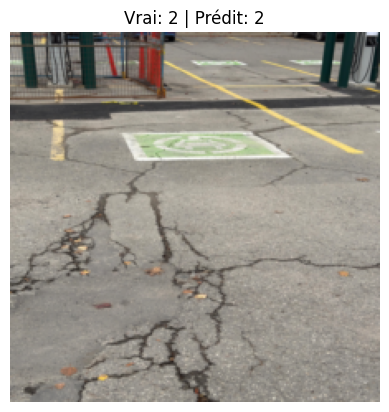

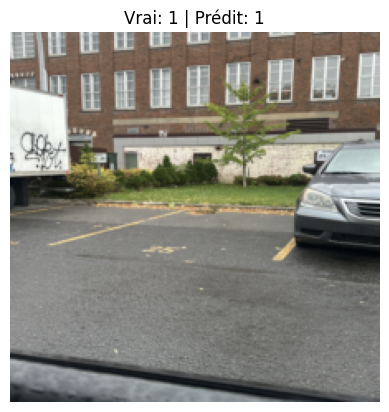

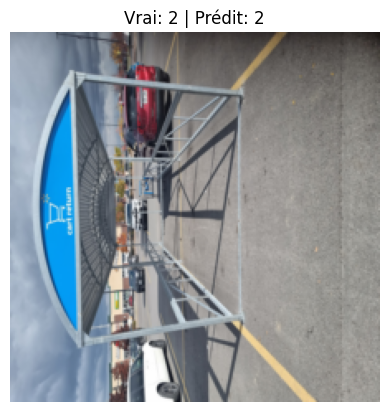

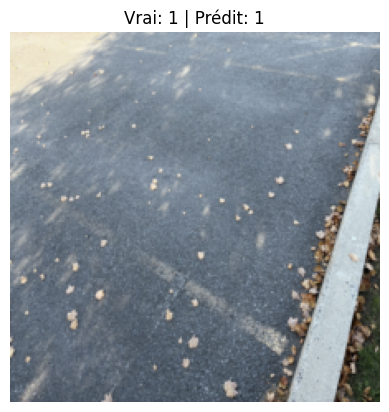

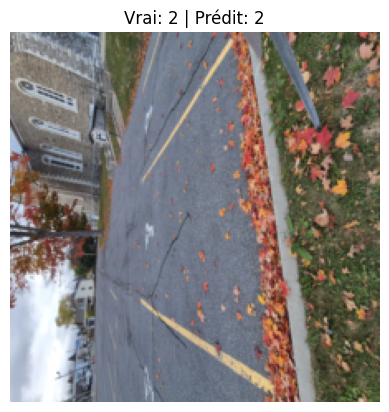

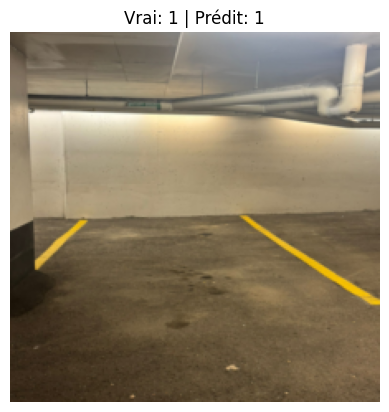

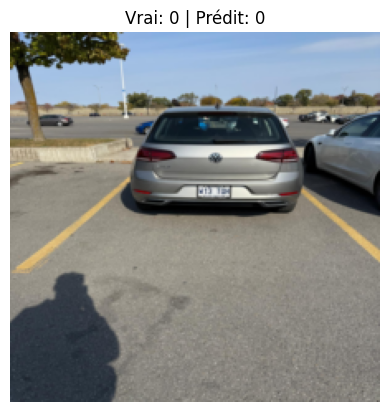

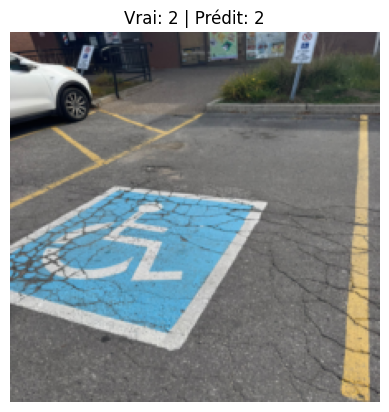

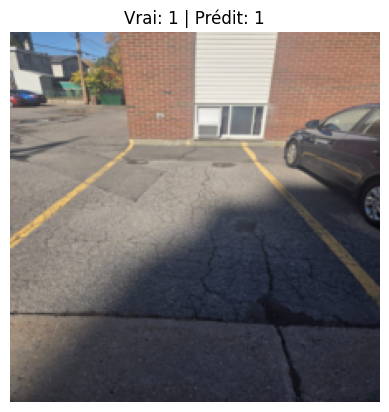

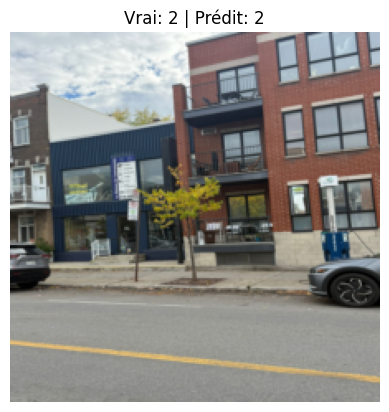

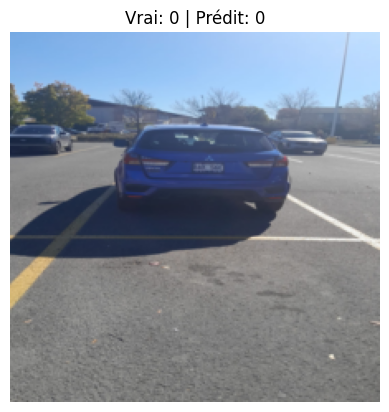

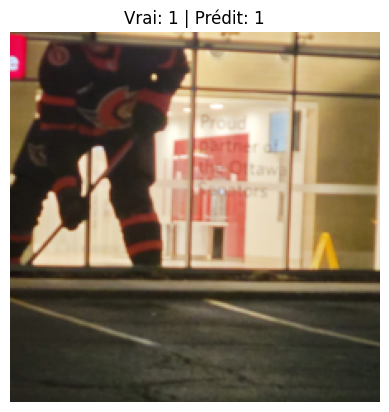

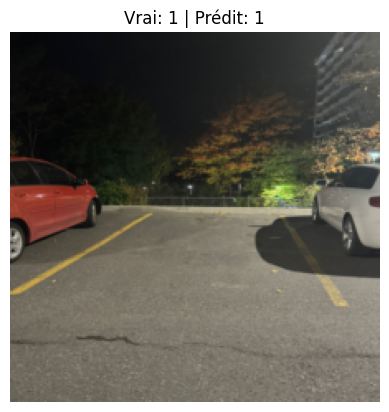

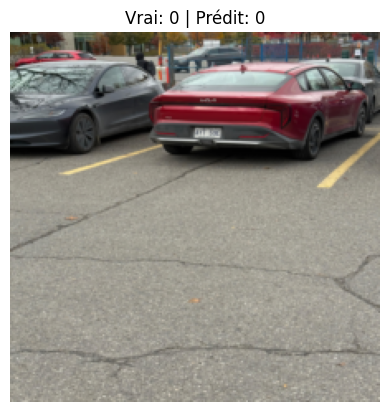

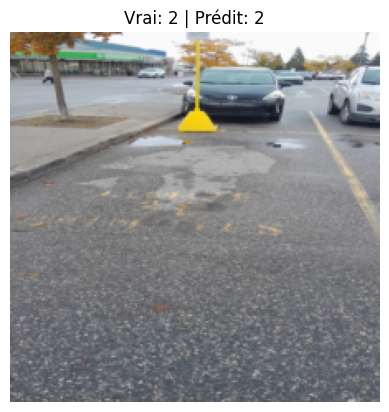

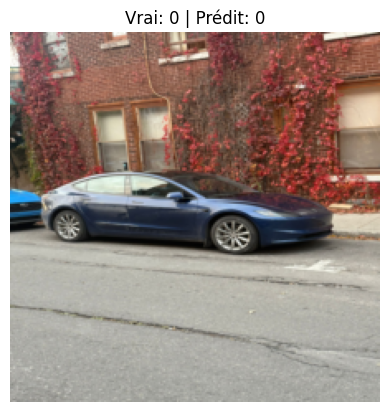

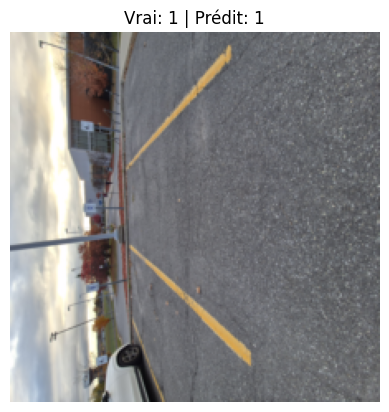

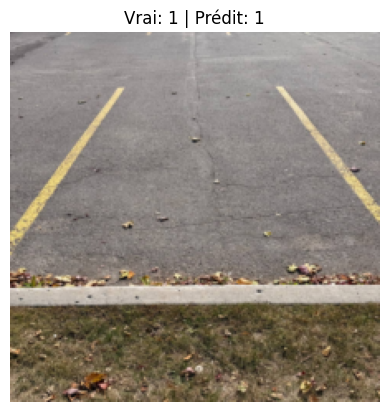

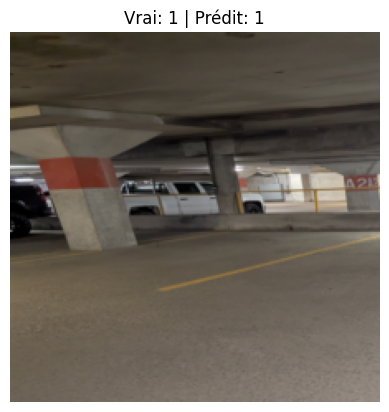

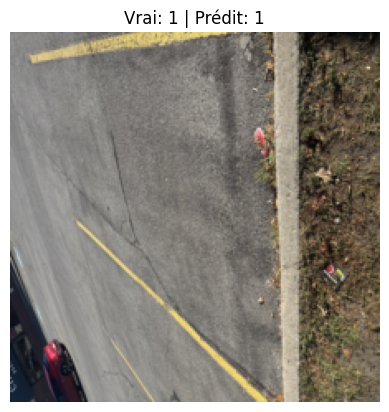

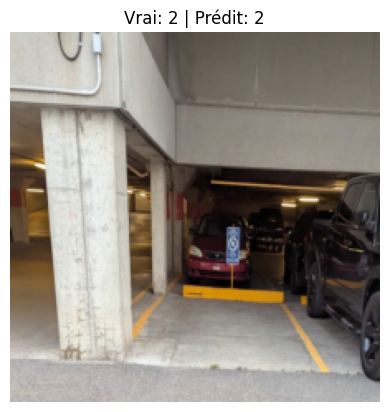

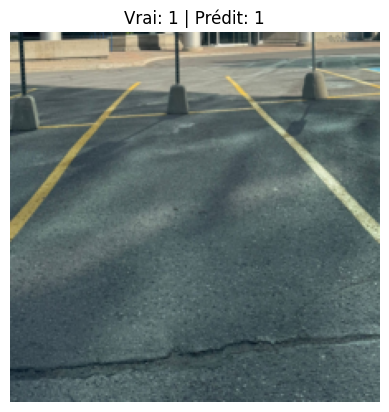

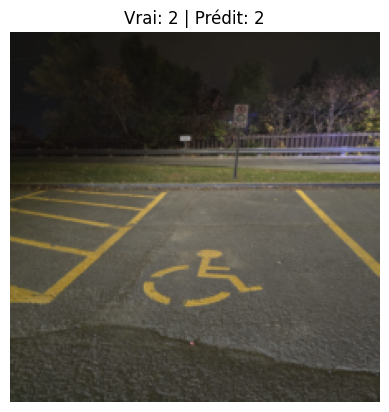

In [64]:
#Afficher les images avec leurs prédictions
for i in range(len(images)):
    # Déplacer l'image et les labels sur CPU pour affichage
    imshow(images[i].cpu(), title=f"Vrai: {labels[i].item()} | Prédit: {preds[i].item()}")

Documentation et difficultés

Le modèle atteint une très haute précision de 96.57 %, ce qui indique une excellente capacité à différencier les trois classes de parking. Cependant, la matrice montre encore quelques confusions entre les classes 1 et 2 mais c'est une petite confusion.
Le plus difficile pour le modèle c'est de differencier la classe 1 de la classe 2, on obtient:
5 cas de la classe 2 ont été prédits comme appartenant à la classe 1.
2 cas de la classe 1 ont été pris pour la classe 2. Cette difficulté peut s'expliquer par le problème de visibilité comme les lignes des parkings et la taille du panneau ou le symbole qui caractérise la classe 2.
Il a reconnu la classe 0 très bien avec une seule erreur sur 62. Cela est peut-etre due au fait qu'un des vehicules dans les images était visible partiellement


Les améliorations qu'on peut effectuer sont:
- Recadrage automatique pour détecter et centrer la zone de stationnement
- Résolution plus fine 256×256 pour améliorer la visibilité des symboles ou panneaux.


Analyse Comparative et Conclusion

Modèle 1 : CNN Simple

Précision : 65.24 %

Analyse :

- Bonne reconnaissance de la classe 0  avec 55/68 bien prédites.
- Confusion entre classe 1 et classe 2 à cause de la ressemblance visuelle comme le même type de sol, mêmes lignes
- Difficulté à distinguer les symboles ou panneaux des places réservées.

Hypothèses :

- Architecture trop simple pour capter les détails fins comme les symboles et marquages
- Images parfois floues, sombres ou prises sous des angles invisibles.

Amélioration possible :

- Augmenter les couches convolutionnelles adaptées du CNN simple
- Ajuster le taux d’apprentissage et l’optimiseur.

Modèle 2 : CNN avec Augmentation

Précision : 77.25 %

Analyse :

- Amélioration globale de la performance.
- Moins de confusion entre classe 1 et classe 2.
- La classe 0 reste bien reconnue 
 
Transformations:

- RandomResizedCrop(224) qui apprend à reconnaître peu importe la position ou la taille.
- RandomHorizontalFlip(0.5) qui rend le modèle pareil à la symétrie.

Hypothèses :

- Problème pour différencier les marquages donc confusion entre certaines classe


Améliorations possible:

- Choisir des augmentations adaptées en fonction des données 
- Augmenter ou diminuer les couches de convolution selon le plus adapté


  
Modèle 3 : CNN par Transfert avec ResNet18

Précision : 96.57 %


Analyse :

- Excellente distinction globale.
- Petite Confusion entre classe 1 et classe 2 
- Les erreurs viennent d’une mauvaise visibilité des symboles ou panneaux.


Améliorations possible:

- Recadrer automatiquement la zone de stationnement.
- Utiliser une résolution plus fine avec 256×256


Conclusion


Le ResNet18 est le meilleur modèle.Il est rapide à performer, il est précis, et très performant pour les prédictions. Après ce modèle vient le CNN avec augmentations qui est plus performant que le CNN simple de base mais il reste moins performant qu'un modèle pré-entrainé comme le resNet18